Index(['Time (sec)', 'Water Level (ft)', 'Water Flowrate (GPM)',
       'House Steam Pressure (psig)', 'Steam Pressure (psig)',
       'Inlet Water Temperature (C)', 'Outlet Water Temperature (C)',
       'Makeup Temperature (C)', 'Makeup Flowrate (L/min)',
       'Ambient Temperature (C)', 'Ambient Pressure (kPa)',
       'Flow Setpoint (GPM)', 'Flow Control Output (%)', 'Level Setpoint (ft)',
       'Level Control Output (%)', 'Steam Setpoint (psig)',
       'Steam Control Output (%)', 'Tube-Side Pressure Drop (psig)'],
      dtype='object')
0.10638778762843985


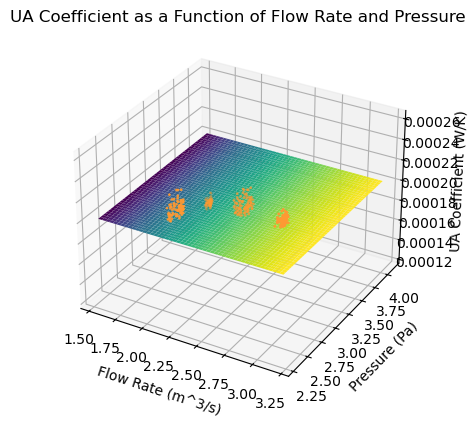

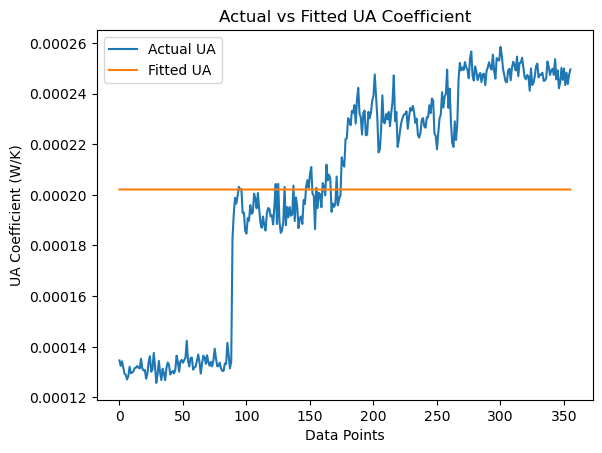

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.optimize as opt
from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

from pathlib import Path
import os
import sys
from byutpl.properties import water as water


# ----- Constants ----- #
# heat exchanger physical parameters
di = .206 * 2.54 / 100                  # m
do = .25 * 2.54 / 100                   # m
L = 14 * 2.54 / 100                     # m
k = 13.4                                # W/m.K 316 SS
g = 9.81                                # m/s^2
N = 56                                  # number of tubes    

# calculate the heat transfer area
Ai = .25 * np.pi * di**2
Ao = .25 * np.pi * do**2

# ----- Functions ----- #
def hi(Qi,Ti):
    # calculate the velocity
    v = Qi / Ai

    # calculate the Reynolds number
    Re = water.ldn(Ti) * v * di / water.lvs(Ti)

    # calculate the Nusselt number
    if Re < 10000:
        Nu = 3.66
    else:
        Nu = .023 * (Re**.8) * water.lpr(Ti)**.4

    # calculate heat transfer coefficient
    h = Nu * water.ltc(Ti) / di
    return h

def ho(Ps,Ts):
    # pull in the values
    rhol = water.ldn(Ts)
    rhov = water.vdn(Ts,Ps)
    kl = water.ltc(Ts)
    mul = water.lvs(Ts)
    Tsat = water.tsat(Ps)
    cpl = water.lcp(Ts) / water.mw
    hfg = water.hvp(Ts) / water.mw

    # find Ja
    Ja = cpl * (Tsat - Ts) / hfg

    # calculate the condensation energy
    hfp = hfg * (1 + (.68 * Ja))

    # calculate the heat transfer coefficient
    h = .729 * (rhol * g * (rhol - rhov) * hfp * kl**3 / (N * mul * (Tsat - Ts) * do))**.25
    return h

hi_vec = np.vectorize(hi)
ho_vec = np.vectorize(ho)


def model(inputs,Rf):
    Qwd,Psd,Tweffd = inputs

    #                       |                 |                                 |
    #      convection_inner | fouling_inner   |             conduction          | convection_outer
    #                       |                 |                                 |
    UA = ((hi_vec(Qwd, Tweffd) * Ai)**-1 + (Rf / Ai) + (np.log(do / di) / (2 * np.pi * k * L)) + (ho_vec(Psd, Tweffd) / Ao)**-1)**-1
    # print(UA)
    return UA




# data1 = pd.read_csv('data/Trial1.csv')
# data2 = pd.read_csv('data/Trial2.csv')
# data3 = pd.read_csv('data/Trial3.csv')
data4 = pd.read_csv('data/Trial4.csv')
data5 = pd.read_csv('data/Trial5.csv')
data6 = pd.read_csv('data/Trial6.csv')
data7 = pd.read_csv('data/Trial7.csv')


data_collection = np.array([data4,data5,data6,data7])
# data_collection = np.array([data1,data2,data3,data4,data5,data6,data7])

print(data4.keys())


qs = np.array([])
Twout = np.array([])
Twin = np.array([])
Ps = np.array([])

for i, df in enumerate(data_collection):
    qs = np.append(qs,df[:,2])
    Twout = np.append(Twout,df[:,6])
    Twin = np.append(Twin,df[:,5])
    Ps = np.append(Ps,df[:,4])

    
Tavg = (Twout + Twin) / 2

# conver the data to SI units
qs_good = qs * 6.30901964e-5                # gal/min to m^3/s
Ps_good = (Ps + 14.7) * 101325 / 14.7       # psig to Pa
Cpw = water.lcp(Tavg + 273.15) / water.mw   # J/kg.K

tsat = np.vectorize(water.tsat)

Tsat = tsat(Ps_good)

# calculate the delta T values
dT1 = Tsat - Twout
dT2 = Tsat - Twin

# calcualate the delta T log mean
dTlm = (dT1 - dT2) / np.log(dT1 / dT2)

# calculate the mass flow rate of the water 
rho = water.ldn(Tavg + 273.15)
m = qs_good / rho

# find the heat transfer
Q = -m * Cpw * (Twin - Twout)

# calculate the heat transfer coefficient
UA = Q / dTlm


# # fit the data with the model
# Rf = curve_fit(model, (qs_good,Ps_good,Tavg + 273.15), UA)

xdata = np.array([qs_good, Ps_good, Tavg + 273.15])  # Stack inputs correctly

# print(xdata)
Rf, _ = curve_fit(model, xdata, UA)
Rf = Rf[0]

print(Rf)

from mpl_toolkits.mplot3d import Axes3D

# Create a 3D mesh grid for flow rate and pressure
flow_rate_range = np.linspace(min(qs_good), max(qs_good), 50)
pressure_range = np.linspace(min(Ps_good), max(Ps_good), 50)
flow_rate_mesh, pressure_mesh = np.meshgrid(flow_rate_range, pressure_range)

# Calculate the UA coefficient for each point in the mesh grid using the fit function
temperature_avg = np.mean(Tavg + 273.15)
UA_mesh = model((flow_rate_mesh, pressure_mesh, temperature_avg), Rf)

# Plot the 3D surface of the UA coefficient
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(flow_rate_mesh * 1000, pressure_mesh / 101325, UA_mesh, cmap='viridis')

ax.scatter(qs_good * 1000, Ps_good / 101325, UA, color = '#ff9933', label='Data Points', s = 1)

ax.set_xlabel('Flow Rate (m^3/s)')
ax.set_ylabel('Pressure (Pa)')
ax.set_zlabel('UA Coefficient (W/K)')
ax.set_title('UA Coefficient as a Function of Flow Rate and Pressure')

plt.show()

# Plot the fit function with the minimized Rf value
UA_fit = model((qs_good, Ps_good, Tavg + 273.15), Rf)

plt.figure()
plt.plot(UA, label='Actual UA')
plt.plot(UA_fit, label='Fitted UA')
plt.xlabel('Data Points')
plt.ylabel('UA Coefficient (W/K)')
plt.legend()
plt.title('Actual vs Fitted UA Coefficient')
plt.show()

In [2]:
# Function using determined fouling factor
# Dictionary of parameters for HX Options

#           Num of Tubes, Di (in),  Do (in),   Length of tubes (in)
HXs = {
    "02008": {"N": 28,  "di": 0.206, "do": 0.250, "L": 8},
    "02014": {"N": 28,  "di": 0.206, "do": 0.250, "L": 14},
    
    "03008": {"N": 56,  "di": 0.206, "do": 0.250, "L": 8},
    "03014": {"N": 56,  "di": 0.206, "do": 0.250, "L": 14},
    "03024": {"N": 56,  "di": 0.206, "do": 0.250, "L": 24},
    "03036": {"N": 56,  "di": 0.206, "do": 0.250, "L": 36},

    "04014": {"N": 108, "di": 0.206, "do": 0.250, "L": 14},
    "04024": {"N": 108, "di": 0.206, "do": 0.250, "L": 24},
    "04036": {"N": 108, "di": 0.206, "do": 0.250, "L": 36},

    "05014": {"N": 80,  "di": 0.331, "do": 0.375, "L": 14},
    "05024": {"N": 80,  "di": 0.331, "do": 0.375, "L": 24},
    "05036": {"N": 80,  "di": 0.331, "do": 0.375, "L": 36},

    "06024": {"N": 116, "di": 0.331, "do": 0.375, "L": 24},
    "06036": {"N": 116, "di": 0.331, "do": 0.375, "L": 36},
    "06048": {"N": 116, "di": 0.331, "do": 0.375, "L": 48},

    "08024": {"N": 210, "di": 0.331, "do": 0.375, "L": 24},
    "08036": {"N": 210, "di": 0.331, "do": 0.375, "L": 36},
    "08048": {"N": 210, "di": 0.331, "do": 0.375, "L": 48},
    "08060": {"N": 210, "di": 0.331, "do": 0.375, "L": 60},
    "08072": {"N": 210, "di": 0.331, "do": 0.375, "L": 72},
    "08084": {"N": 210, "di": 0.331, "do": 0.375, "L": 84},
    "08096": {"N": 210, "di": 0.331, "do": 0.375, "L": 96}
}

In [3]:
print(HXs["03014"])

{'N': 56, 'di': 0.206, 'do': 0.25, 'L': 14}


In [55]:
def HXLIST(hx):
    '''Input a heat exchanger from the list, it returns an output temperature for the system at scale'''
    '''fsolve this function for Tout. It will give the first half of equation 2, or UA * ΔTlm'''
    N  = HXs[hx]['N']   # Number of tubes
    di = HXs[hx]['di'] * 2.54 / 100 # Inner diameter of tubes (inches-> m)
    do = HXs[hx]['do'] * 2.54 / 100 # Outer diameter of tubes (inches-> m)
    L  = HXs[hx]['L']  * 2.54 / 100  # Length of tubes (inches -> m)
    #print(N,di,do,L)
    
    # calculate the heat transfer area
    Ai = np.pi * di * L # inner circumference * tube length
    Ao = np.pi * do * L # outer circumference * tube length
    
    # Conditions at scale
    Q    = 300 * 6.30902e-5 # gal/min -> m3/s
    Tin  = 25 + 273   # degC -> K
    Pressure = (300 + 14.7) * (101325 / 14.7) # psig -> Pa
    k_ss316 = 13.4    # W/m K
    g = 9.81          # m/s2
    Rfi = 0.0012      # m2K/W, as of 2/24
    
    Tsat = water.tsat(Pressure) # fill in later
    
    def UATlm(Tout): # Tout in K
        '''This function will need to calculate UA using equations 1, 3-6'''
        Tavg = (Tin + Tout)/2

        ν    = water.lnu(Tavg)    # kinematic viscosity m2/s
        μl = water.lvs(Tavg)
        ρH2O = water.ldn(Tavg)    # density  kg/m3
        ρsteam = water.vdn(Tavg,Pressure)
        kf   = water.ltc(Tavg)    # thermal conductivity in W/mK
        Pr   = water.lpr(Tavg)    # Prandtl number
        Cp = water.lcp(Tavg) / 0.01802   # J/mol K -> J/kg K
        
        q_per_tube = Q/N
        veloc = q_per_tube/Ai
        
        Re =  veloc*di/ν # velocity * inner diameter / kinematic viscosity
        
        if Re <= 10000:
            '''Laminar'''
            Nu = 3.66
        else:
            '''Turbulent'''
            '''Equation 4'''
            n = 0.4 # for heating
            Nu = 0.023*(Re**0.8)*(Pr**n)

        '''Equation 3'''
        hi = Nu*kf/di

        '''Equation 6'''
        hfg = water.hvp(Tavg) / water.mw
        Ja = Cp * (Tsat - Tavg) / hfg      # Tavg = Ts?
        hfp = hfg * (1 + (.68 * Ja))
        
        '''Equation 5'''
        numer = ρH2O * g * (ρH2O - ρsteam) * hfp * kf**3
        denom = N * μl * (Tsat - Tavg) * do      # Tavg = Ts?
        ho = .729 * (numer/denom)**(1/4)

        '''Equation 1'''
        R_conv_in  = 1/hi/Ai
        R_conv_out = 1/ho/Ao
        R_cond     = np.log(do/di)/2/np.pi/k_ss316/L
        R_fouling  = Rfi / Ai
        print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~\nLeft hand side of EQ 2:")
        #print(f"R_ci = {R_conv_in}\nR_co = {R_conv_out}\nR_cd = {R_cond}\nR_f = {R_fouling}")     # Uncomment for Debugging
        
        UA = 1/ (R_conv_in + R_fouling + R_cond + R_conv_out) 
        
        ΔT1  = Tsat - Tout
        ΔT2  = Tsat - Tin
        ΔTlm = (ΔT2-ΔT1)/np.log(ΔT2/ΔT1)
        print(f"UA = {UA} W/K\nΔTlm = {ΔTlm} K\n")
        
        return UA * ΔTlm        # returns a q value in W

    def Q_func(Tout):           # Tout in K
        '''This function is good to go'''
        Tavg = (Tin + Tout)/2
        ρH2O = water.ldn(Tavg)  # in kg/m3, Tavg in K
        mdot = Q*ρH2O           # kg/s
        Cp = water.lcp(Tavg) / 0.01802   # J/mol K -> J/kg K
        print(f"Right hand side of EQ 2:\nmdot = {mdot} kg/s\nCp = {Cp} J/kg/K\nΔT = {Tin - Tout}K\n")
        return mdot * Cp * (Tin - Tout) # returns a q value in W

    # Solve Equation 2 for outlet temperature
    TOUT = fsolve(lambda T: UATlm(T) - Q_func(T),75+273)[0] - 273 # returns outlet temp in C
    
    return TOUT

print(f"03014: T_out = {HXLIST("03014"):.5f} °C")
#print(f"05024: T_out = {HXLIST("05024"):.5f} °C")
#print(f"08096: T_out = {HXLIST("08096"):.5f} °C")

~~~~~~~~~~~~~~~~~~~~~~~~~~
Left hand side of EQ 2:
UA = [1.49877465] W/K
ΔTlm = [165.51162514] K

Right hand side of EQ 2:
mdot = [18.7012341] kg/s
Cp = [4175.65585684] J/kg/K
ΔT = [-50]K

~~~~~~~~~~~~~~~~~~~~~~~~~~
Left hand side of EQ 2:
UA = [1.49877465] W/K
ΔTlm = [165.51162514] K

Right hand side of EQ 2:
mdot = [18.7012341] kg/s
Cp = [4175.65585684] J/kg/K
ΔT = [-50.]K

~~~~~~~~~~~~~~~~~~~~~~~~~~
Left hand side of EQ 2:
UA = [1.49877465] W/K
ΔTlm = [165.51162514] K

Right hand side of EQ 2:
mdot = [18.7012341] kg/s
Cp = [4175.65585684] J/kg/K
ΔT = [-50.]K

~~~~~~~~~~~~~~~~~~~~~~~~~~
Left hand side of EQ 2:
UA = [1.49877466] W/K
ΔTlm = [165.51162226] K

Right hand side of EQ 2:
mdot = [18.70123408] kg/s
Cp = [4175.65585735] J/kg/K
ΔT = [-50.00000519]K

~~~~~~~~~~~~~~~~~~~~~~~~~~
Left hand side of EQ 2:
UA = [1.42430937] W/K
ΔTlm = [192.02857428] K

Right hand side of EQ 2:
mdot = [18.87217466] kg/s
Cp = [4183.73789034] J/kg/K
ΔT = [0.52050765]K

~~~~~~~~~~~~~~~~~~~~~~~~~~
Left han

In [5]:
#help(water)